In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F  # Ensure this import is added

from torch.utils.data import DataLoader, TensorDataset
import gymnasium 
import mon_env
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

### CNN 1 : RGB 

In [26]:
# Parameters
sequence_length = 2  # Number of images in each sequence, IL FAUT TESTER AVEC 2 P-E CA CHANGE TOUT 
num_episodes = 500   ### JOUER AVEC CE PARAMETRE POUR AMELIORER LE MODELE : TESTER AVEC 1000 SERAIT COOL

# Environment Setup
env = gymnasium.make('MonCartPole-v1',render_mode="rgb_array")
data_images = []
data_states = []

# Transformation for images
transform = transforms.Compose([transforms.ToPILImage(), 
                    transforms.Resize(60, interpolation=Image.LANCZOS),
                    transforms.ToTensor()])


# Cart location for centering image crop
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# Cropping, downsampling (and Grayscaling) image
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Resize, and add a batch dimension (BCHW)
    screen = torch.from_numpy(screen)
    return transform(screen)

In [27]:

# Data Collection using Heuristic Policy
for episode in range(num_episodes):
    observation = env.reset()[0]
    images = [torch.zeros(3, 60, 135) for _ in range(sequence_length)]
           
    for t in range(1000):
        tensor_image = get_screen()  # Transform image immediately
        # if t==4:
        #     print(tensor_image.shape)
        #     plt.imshow(np.array(tensor_image.permute(1,2,0)))
        images.append(tensor_image)
        
        if len(images) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images[-sequence_length:], dim=0).permute(1, 0, 2, 3)
            data_images.append(sequence_tensor)
            data_states.append(observation)
        
        action = env.action_space.sample()  
        observation, reward, done, info, _ = env.step(action)
        if done:
            break

env.close()

# Convert data_states to a tensor
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


In [28]:
# Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
        )
        # Correctly calculate the input size for the linear layer based on the output from conv_layers
        self.fc_layers = nn.Sequential(
            nn.Linear(int(63360/2), 128),  # Adjusted based on actual output size #63360/2
            nn.ReLU(),
            nn.Linear(128, 4)  # Predicting 4 state variables
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc_layers(x)
        return x

In [29]:
# Model instantiation and training setup
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10 # Peut-être avec plus d'epoch on obtiendrait un meilleur résultat ? jsp
for epoch in range(num_epochs):
    for images, states in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')



Epoch 1, Loss: 0.0643385499715805
Epoch 2, Loss: 0.013731541112065315
Epoch 3, Loss: 0.028273921459913254
Epoch 4, Loss: 0.050622984766960144
Epoch 5, Loss: 0.014159468933939934
Epoch 6, Loss: 0.028432276099920273
Epoch 7, Loss: 0.03141402080655098
Epoch 8, Loss: 0.09023912996053696
Epoch 9, Loss: 0.002768975216895342
Epoch 10, Loss: 0.043720047920942307


In [30]:
# Save the model
torch.save(model.state_dict(), 'cartpole_cnn_rgb_enhanced_2_img_2.pth')

In [37]:
# Voir un peu ce que ça donne

model.eval()
for images, states in dataloader:
    print(images.shape,states.shape)
    print(model(images[0].unsqueeze(0)),states[0])
    break

torch.Size([10, 3, 2, 60, 135]) torch.Size([10, 4])
tensor([[0.0071, 0.0142, 0.0027, 0.0002]], grad_fn=<AddmmBackward0>) tensor([-0.0318,  0.0131, -0.0086, -0.0153])


torch.Size([10, 4]) torch.Size([10, 2, 60, 135, 3])
torch.Size([60, 135, 3])
torch.Size([60, 135, 3])
tensor([ 0.0461,  0.1650,  0.0089, -0.3010])


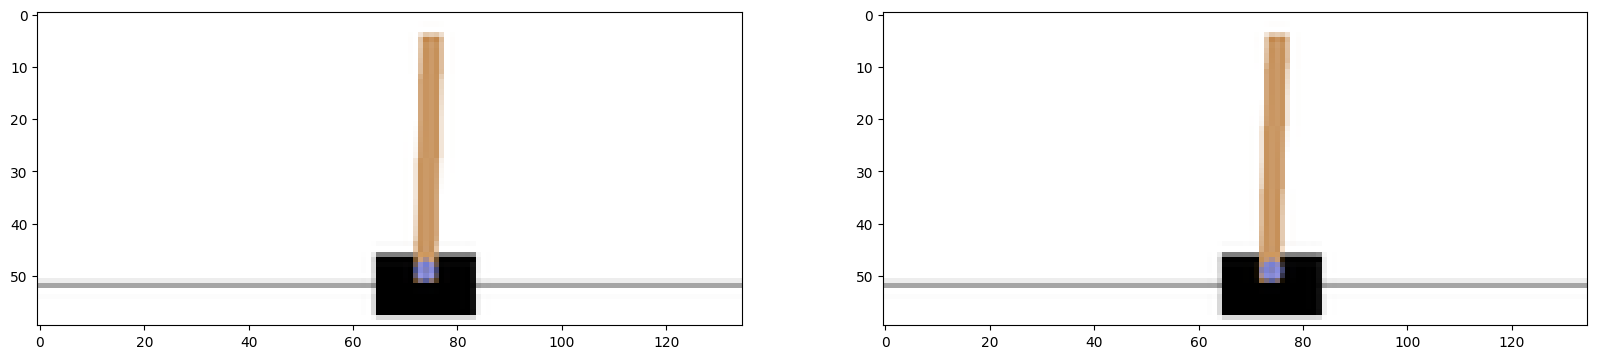

In [45]:
for images, labels in dataloader:
    images = images.permute((0,2,3,4,1))
    print(labels.shape,images.shape)
    fig,axes = plt.subplots(1,sequence_length,figsize = (20,30))
    for i in range(sequence_length):
        axes[i].imshow(images[0][i])
        print(images[0][i].shape)
    print(labels[0])

    break

In [5]:
model = CNN()
model = torch.load(model.state_dict(), 'cartpole_cnn_rgb.pth')
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [46]:
# Voir encore mieux ce que ça donne

# 1 : On collecte des images du cartpole (heuristique : random)

env = gymnasium.make('MonCartPole-v1',render_mode="rgb_array")
data_images_bis = []
data_states_bis = []

for episode in range(3):
    observation_bis = env.reset()[0]
    images_bis = []
    for t in range(1000):
        img = get_screen()
        # img_pil = Image.fromarray(img)
        tensor_image = transform(img)  # Transform image immediately
        images_bis.append(tensor_image)
        
        if len(images_bis) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images_bis[-sequence_length:], dim=0).permute(1, 0, 2, 3)
            data_images_bis.append(sequence_tensor)
            data_states_bis.append(observation)
        
        action = env.action_space.sample()   # Use the heuristic policy
        observation, reward, done, info, _ = env.step(action)
        if done:
            break
data_states_bis = torch.tensor(data_states_bis, dtype=torch.float32)

# Dataset and DataLoader
data_images_bis = torch.stack(data_images_bis)

In [47]:
# 2 Afficher ce que prédit le modèle vs les vraies observations

model.eval()
total = 0 # Loss totale
for images, states in zip(data_images_bis, data_states_bis):
    with torch.no_grad():
        print(model(images.unsqueeze(0)),states)
        total += np.sum(np.array((model(images.unsqueeze(0))-states)**2))

print(total)

tensor([[-3.7380e-02, -1.8578e-02,  1.2642e-03,  2.5662e-05]]) tensor([-0.0419,  0.1784,  0.0120, -0.3325])
tensor([[-0.0307,  0.1369,  0.0111, -0.2131]]) tensor([-0.0383, -0.0169,  0.0054, -0.0361])
tensor([[-0.0392,  0.0151,  0.0114, -0.0105]]) tensor([-0.0387,  0.1781,  0.0047, -0.3270])
tensor([[-0.0359,  0.2437, -0.0032, -0.3744]]) tensor([-0.0351,  0.3732, -0.0019, -0.6182])
tensor([[-0.0261,  0.3148, -0.0050, -0.4424]]) tensor([-0.0276,  0.1781, -0.0142, -0.3262])
tensor([[-0.0119,  0.1968, -0.0091, -0.3199]]) tensor([-0.0241,  0.3734, -0.0208, -0.6233])
tensor([[-0.0049,  0.3752, -0.0271, -0.6239]]) tensor([-0.0166,  0.1786, -0.0332, -0.3372])
tensor([[-0.0007,  0.1463, -0.0460, -0.3060]]) tensor([-0.0130,  0.3742, -0.0400, -0.6402])
tensor([[-0.0014,  0.3388, -0.0438, -0.6239]]) tensor([-0.0056,  0.1796, -0.0528, -0.3604])
tensor([[ 0.0045,  0.2130, -0.0523, -0.4138]]) tensor([-0.0020,  0.3755, -0.0600, -0.6692])
tensor([[ 0.0108,  0.3091, -0.0598, -0.6023]]) tensor([ 0.0055, 

In [10]:
torch.save(model.state_dict(), 'gotta_test_that_one.pth')

### CNN 2 : GREY

In [13]:
# Parameters
sequence_length = 2  # Number of images in each sequence
num_episodes = 20   # Number of episodes for data collection


# Environment Setup
env = gymnasium.make('MonCartPole-v1', render_mode = 'rgb_array')
data_images = []
data_states = []

# Transformer les images et les convertir en tenseurs
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((60, 135)),
    transforms.Grayscale()
])

In [15]:
# Cart location for centering image crop
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# Cropping, downsampling (and Grayscaling) image
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Resize, and add a batch dimension (BCHW)
    return transform(screen.transpose(1,2,0)).squeeze(0)


In [16]:

# Collecter les données

for episode in range(num_episodes):
    observation = env.reset()[0]
    images = [torch.zeros(60, 135) for _ in range(sequence_length)]
    for t in range(1000):
        img = env.render()
        tensor_image = get_screen()
        # if t == 5:
        #     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Crée une figure et des axes avec 1 ligne et 'n_images' colonnes
        #     axes[0].imshow(tensor_image)
        
        images.append(tensor_image)
        sequence_tensor = torch.stack(images[-sequence_length:], dim=0)
        data_images.append(sequence_tensor)
        data_states.append(observation)

        action = env.action_space.sample()  
        observation, reward, done, info, _ = env.step(action)
        if done:
            break

# env.close()

# Convert data_states to a tensor 
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [17]:
class CartPoleCNN(nn.Module):
    def __init__(self):
        super(CartPoleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2),  # Input: 4 gray images, output: 16 channels, 60x135
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: ? 30x67
            # nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPoold(kernel_size=2, stride=2),                 # Output size: ? 15x33
            # nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)                  # Output size: ? 7x16
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64320, 128),
            nn.ReLU(),
            nn.Linear(128,4)    # x, x_dot, theta, theta_dot
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return x

# Instanciation du modèle
model = CartPoleCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([10, 4]) torch.Size([10, 2, 60, 135])
tensor([-0.0579, -0.3469, -0.0022,  0.4842])


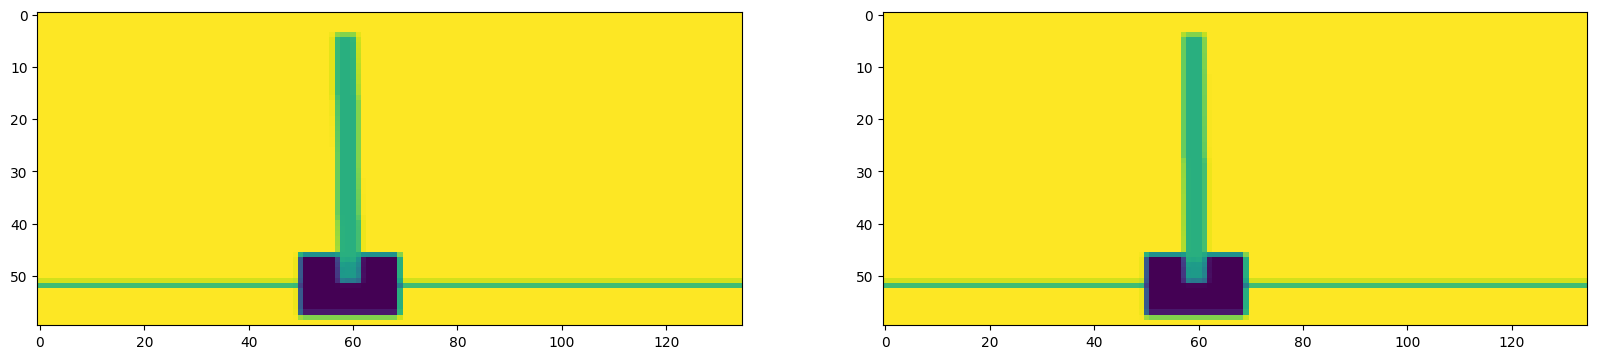

In [8]:
for images, labels in dataloader:
    print(labels.shape,images.shape)
    fig,axes = plt.subplots(1,sequence_length,figsize = (20,30))
    for i in range(sequence_length):
        axes[i].imshow(images[0][i])
    print(labels[0])

    break

In [9]:
env.close()

In [18]:
# Training Loop
num_epochs = 500 # Peut-être avec plus d'epoch on obtiendrait un meilleur résultat ? jsp
model.train()
for epoch in range(num_epochs):
    for images, states in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.12795905768871307
Epoch 2, Loss: 0.16815049946308136
Epoch 3, Loss: 0.1672208309173584
Epoch 4, Loss: 0.06543080508708954
Epoch 5, Loss: 0.30774927139282227
Epoch 6, Loss: 0.07811008393764496
Epoch 7, Loss: 0.36342111229896545
Epoch 8, Loss: 0.12097403407096863
Epoch 9, Loss: 0.17208515107631683
Epoch 10, Loss: 0.3119887411594391
Epoch 11, Loss: 0.5892882943153381
Epoch 12, Loss: 0.14269417524337769
Epoch 13, Loss: 0.13215647637844086
Epoch 14, Loss: 0.26543083786964417
Epoch 15, Loss: 0.11028491705656052
Epoch 16, Loss: 0.20775824785232544
Epoch 17, Loss: 0.522468626499176
Epoch 18, Loss: 0.11789672076702118
Epoch 19, Loss: 0.34402769804000854
Epoch 20, Loss: 0.2593497633934021
Epoch 21, Loss: 0.064568430185318
Epoch 22, Loss: 0.14318951964378357
Epoch 23, Loss: 0.22737151384353638
Epoch 24, Loss: 0.40478453040122986
Epoch 25, Loss: 0.28532418608665466
Epoch 26, Loss: 0.4295632243156433
Epoch 27, Loss: 0.15064340829849243
Epoch 28, Loss: 0.3069468140602112
Epoch 29, L

KeyboardInterrupt: 

In [204]:
# Voir encore mieux ce que ça donne

# 1 : On collecte des images du cartpole (heuristique : random)

env = gymnasium.make('CartPole-v1', render_mode = 'rgb_array')
data_images_bis = []
data_states_bis = []

for episode in range(3):
    observation_bis = env.reset()[0]
    images_bis = []
    for t in range(1000):
        img = env.render()
        tensor_image = transform(img).squeeze(0)  # Transform image immediately
        images_bis.append(tensor_image)
        
        if len(images_bis) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images_bis[-sequence_length:], dim=0)
            data_images_bis.append(sequence_tensor)
            data_states_bis.append(observation)
        
        action = env.action_space.sample()   # Use the heuristic policy
        observation, reward, done, info, _ = env.step(action)
        if done:
            break
data_states_bis = torch.tensor(data_states_bis, dtype=torch.float32)

# Dataset and DataLoader
data_images_bis = torch.stack(data_images_bis)

In [206]:
# 2 Afficher ce que prédit le modèle vs les vraies observations

model.eval()
total = 0 # Loss totale
for images, states in zip(data_images_bis, data_states_bis):
    with torch.no_grad():
        print(model(images.unsqueeze(0)),states)
        total += np.sum(np.array((model(images.unsqueeze(0))-states)**2))

print(total)

tensor([[0.0171, 0.0640, 0.0296, 0.1519]]) tensor([ 0.0223,  0.1958,  0.0023, -0.2450])
tensor([[ 0.0019, -0.0086,  0.0220,  0.1821]]) tensor([ 0.0262,  0.0006, -0.0026,  0.0484])
tensor([[0.0145, 0.0682, 0.0334, 0.1532]]) tensor([ 0.0262,  0.1958, -0.0016, -0.2451])
tensor([[ 0.0069, -0.0092,  0.0262,  0.2019]]) tensor([ 0.0301,  0.3909, -0.0065, -0.5383])
tensor([[0.0034, 0.0329, 0.0279, 0.1633]]) tensor([ 0.0380,  0.1959, -0.0173, -0.2477])
tensor([[0.0030, 0.0586, 0.0364, 0.1539]]) tensor([ 0.0419,  0.0010, -0.0222,  0.0395])
tensor([[0.0073, 0.0549, 0.0386, 0.1589]]) tensor([ 0.0419, -0.1938, -0.0214,  0.3251])
tensor([[0.0163, 0.0125, 0.0331, 0.2098]]) tensor([ 0.0380, -0.3886, -0.0149,  0.6109])
tensor([[0.0212, 0.0400, 0.0332, 0.1914]]) tensor([ 0.0302, -0.1933, -0.0027,  0.3136])
tensor([[0.0103, 0.0421, 0.0354, 0.1772]]) tensor([ 0.0264, -0.3884,  0.0036,  0.6054])
tensor([[0.0264, 0.0304, 0.0305, 0.1945]]) tensor([ 0.0186, -0.5835,  0.0157,  0.8992])
tensor([[ 0.0078, -0.055

In [207]:
torch.save(model.state_dict(), 'cnn_grey_enhanced_2500.pth')

In [14]:
env.close()

### 3 - Uniform Sampling

In [19]:
# Parameters
sequence_length = 2  # Number of images in each sequence
num_episodes = 20   # Number of episodes for data collection

# Environment Setup
env = gymnasium.make('MonCartPole-v1', render_mode = 'rgb_array')
data_images = []
data_states = []

x_threshold = env.x_threshold
theta_threshold = env.theta_threshold_radians
# On prend quoi pour x_dot et theta_dot ?? Compliqué, prendre de manière random
# semble peu pertinent car dépendent directement de x et theta...

C:\Users\hatem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.x_threshold to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x_threshold` for environment variables or `env.get_wrapper_attr('x_threshold')` that will search the reminding wrappers.
  logger.warn(
C:\Users\hatem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.theta_threshold_radians to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.theta_threshold_radians` for environment variables or `env.get_wrapper_attr('theta_threshold_radians')` that will search the reminding wrappers.
  logger.warn(
